
# Neonatal Jaundice — Deep Learning Models (CNN, ResNet50, EfficientNetB0, VGG16)

This notebook is a **cleaned version** focused **only** on deep learning models:
- Simple **CNN** (from scratch)
- **ResNet50** (transfer learning)
- **EfficientNetB0** (transfer learning)
- **VGG16** (transfer learning)


we will train/evaluate each model and compare metrics (Accuracy, Precision, Recall, F1, ROC AUC) plus a confusion matrix.


## 1) Setup & Imports

In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc

# For reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(tf.__version__)


2025-12-07 13:27:07.157298: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.2


## 2) Data Paths & Generators

In [3]:
import os, glob
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

normal_dir   = "jaundice-image-data/normal"
jaundice_dir = "jaundice-image-data/jaundice"

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
SEED       = 42
NUM_CLASSES = 1 

# 2) Build dataframe of file paths + labels
normal_files   = glob.glob(os.path.join(normal_dir,   "**", "*.*"), recursive=True)
jaundice_files = glob.glob(os.path.join(jaundice_dir, "**", "*.*"), recursive=True)

df = pd.DataFrame({
    "filepath": normal_files + jaundice_files,
    "label":    ["normal"] * len(normal_files) + ["jaundice"] * len(jaundice_files)
})

# Keep image files only
df = df[df["filepath"].str.lower().str.endswith((".png",".jpg",".jpeg",".bmp",".tif",".tiff"))].reset_index(drop=True)

# 3) Train / Val / Test split (stratified) - PERFECT 70/15/15 split
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df["label"],
    random_state=SEED
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label"],
    random_state=SEED
)

print("Counts -> train:", train_df["label"].value_counts().to_dict(),
      "val:",   val_df["label"].value_counts().to_dict(),
      "test:",  test_df["label"].value_counts().to_dict())

# 4) Helper to create generators for different preprocess functions (UPDATED WITH TEST)
def make_gens(preprocess_fn=None):
    if preprocess_fn is None:
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True
        )
        val_datagen = ImageDataGenerator(rescale=1./255)
        test_datagen = ImageDataGenerator(rescale=1./255)  # NEW: test gets no augmentation
    else:
        train_datagen = ImageDataGenerator(
            preprocessing_function=preprocess_fn,
            rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True
        )
        val_datagen = ImageDataGenerator(preprocessing_function=preprocess_fn)
        test_datagen = ImageDataGenerator(preprocessing_function=preprocess_fn)  # NEW: test gets preprocess only

    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="filepath",
        y_col="label",
        target_size=IMG_SIZE,
        class_mode="binary",
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=SEED
    )
    val_gen = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col="filepath",
        y_col="label",
        target_size=IMG_SIZE,
        class_mode="binary",
        batch_size=BATCH_SIZE,
        shuffle=False
    )
    # NEW: Test generator (no shuffle, same preprocessing as val)
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="filepath",
        y_col="label",
        target_size=IMG_SIZE,
        class_mode="binary",
        batch_size=BATCH_SIZE,
        shuffle=False   # CRITICAL: no shuffle for consistent predictions
    )
    return train_gen, val_gen, test_gen

# 5) Create model-specific generators (UPDATED WITH TEST)
cnn_train_gen,    cnn_val_gen,    cnn_test_gen    = make_gens(preprocess_fn=None)
resnet_train_gen, resnet_val_gen, resnet_test_gen = make_gens(preprocess_fn=resnet_preprocess)
eff_train_gen,    eff_val_gen,    eff_test_gen    = make_gens(preprocess_fn=efficientnet_preprocess)
vgg_train_gen,    vgg_val_gen,    vgg_test_gen    = make_gens(preprocess_fn=vgg_preprocess)

print("Class indices (CNN view):", cnn_train_gen.class_indices)
print(f"Test set ready: {len(cnn_test_gen)} batches")

Counts -> train: {'normal': 392, 'jaundice': 140} val: {'normal': 84, 'jaundice': 30} test: {'normal': 84, 'jaundice': 30}
Found 532 validated image filenames belonging to 2 classes.
Found 114 validated image filenames belonging to 2 classes.
Found 114 validated image filenames belonging to 2 classes.
Found 532 validated image filenames belonging to 2 classes.
Found 114 validated image filenames belonging to 2 classes.
Found 114 validated image filenames belonging to 2 classes.
Found 532 validated image filenames belonging to 2 classes.
Found 114 validated image filenames belonging to 2 classes.
Found 114 validated image filenames belonging to 2 classes.
Found 532 validated image filenames belonging to 2 classes.
Found 114 validated image filenames belonging to 2 classes.
Found 114 validated image filenames belonging to 2 classes.
Class indices (CNN view): {'jaundice': 0, 'normal': 1}
Test set ready: 4 batches


Total images: 760
Label distribution: {'normal': 560, 'jaundice': 200}


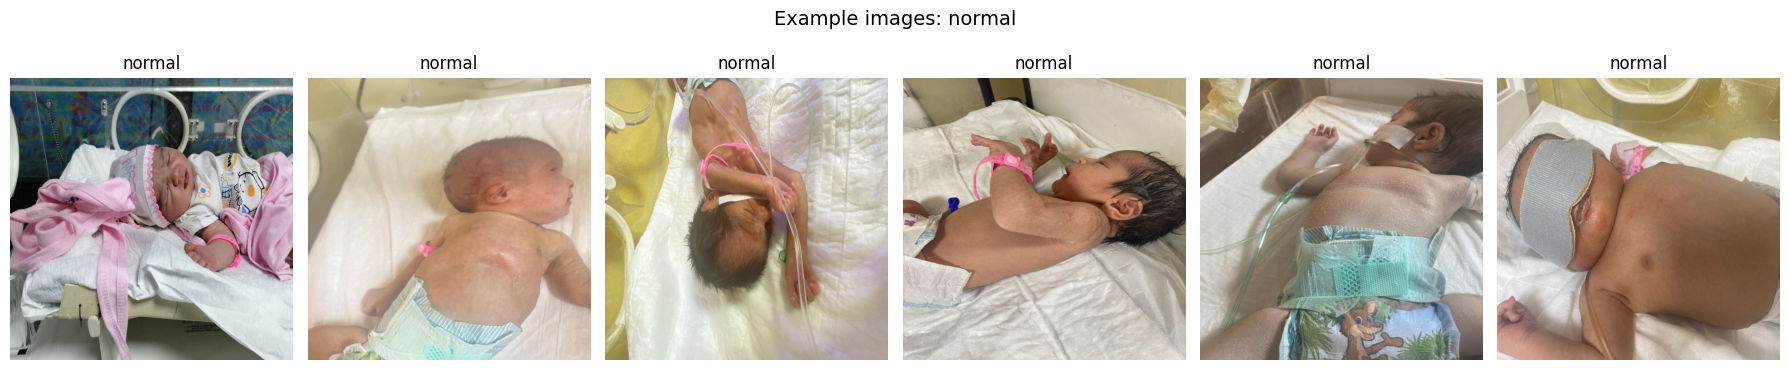

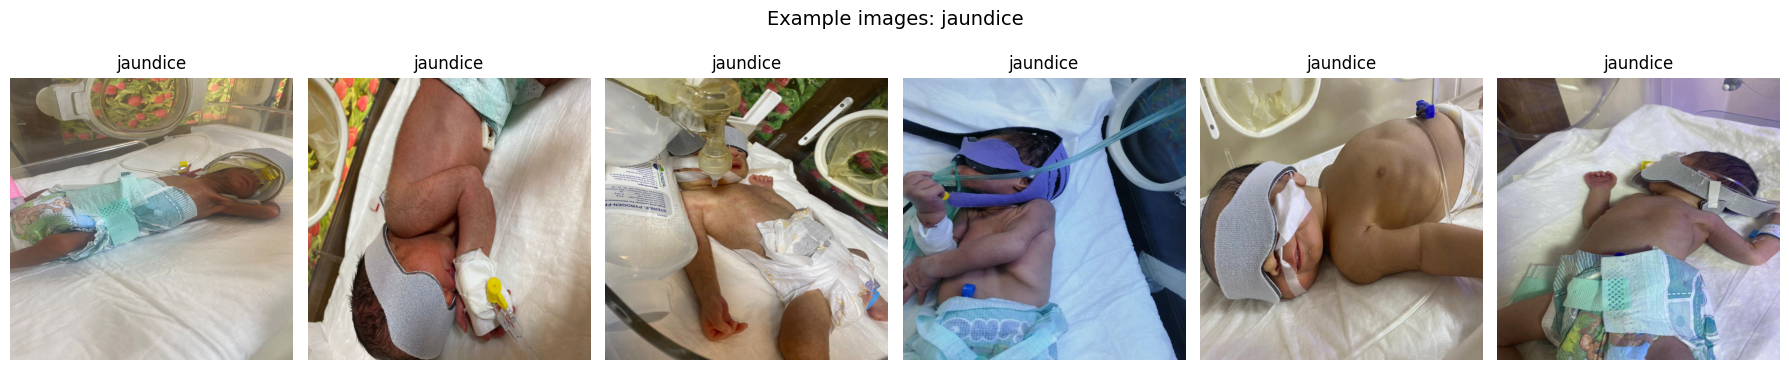

In [5]:
# Quick sanity checks & image visualization

print("Total images:", len(df))
print("Label distribution:", df['label'].value_counts().to_dict())

def show_samples(df, label, n=6):
    """Plot up to n random images for a given label from the dataframe."""
    subset = df[df['label'] == label]
    n = min(n, len(subset))
    if n == 0:
        print(f"No images found for label={label}")
        return
    sample = subset.sample(n, random_state=SEED)

    plt.figure(figsize=(3*n, 4))
    for i, fp in enumerate(sample['filepath'], start=1):
        try:
            img = Image.open(fp).convert("RGB")
            plt.subplot(1, n, i)
            plt.imshow(img)
            plt.title(label)
            plt.axis("off")
        except Exception as e:
            print(f"Could not load {fp}: {e}")
    plt.suptitle(f"Example images: {label}", fontsize=14)
    plt.tight_layout()
    plt.show()

show_samples(df, "normal", n=6)
show_samples(df, "jaundice", n=6)


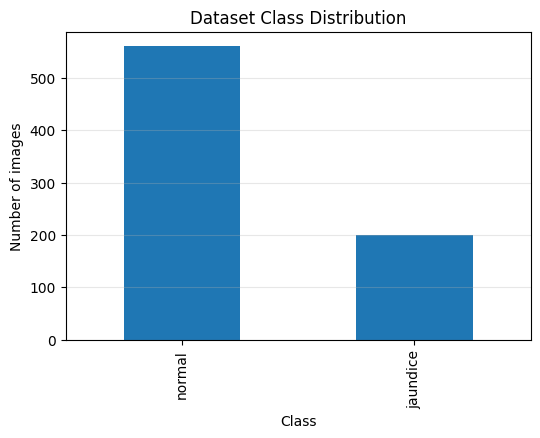

In [7]:
plt.figure(figsize=(6,4))
df['label'].value_counts().plot(kind='bar')
plt.title("Dataset Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.grid(axis="y", alpha=0.3)
plt.show()

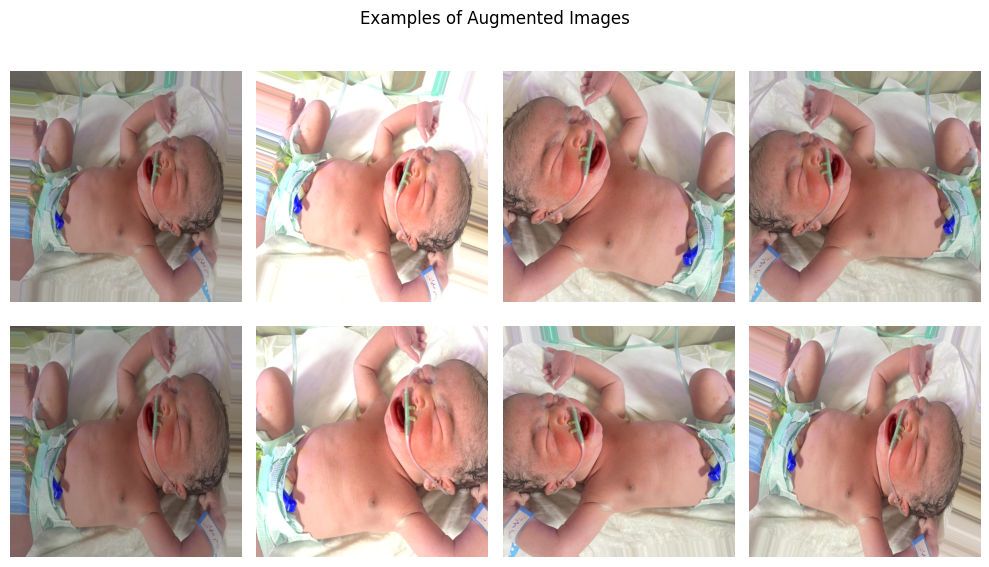

In [9]:
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# use your augmentation settings
datagen = ImageDataGenerator(
    rotation_range=20,
    brightness_range=[0.7, 1.3],
    zoom_range=0.2,
    horizontal_flip=True
)

# pick a random image from the dataframe
img_path = random.choice(df['filepath'].tolist())

img = load_img(img_path)
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

# visualize 8 augmented versions
plt.figure(figsize=(10,6))
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(2, 4, i+1)
    plt.imshow(batch[0].astype("uint8"))
    plt.axis("off")
    i += 1
    if i == 8:
        break

plt.suptitle("Examples of Augmented Images")
plt.tight_layout()
plt.show()


## 3) Metrics Utilities

In [11]:
import random


def print_metrics(name, y_true, y_pred_probs, threshold=0.5):
    y_pred_bin = (y_pred_probs >= threshold).astype(int).ravel()
    acc = accuracy_score(y_true, y_pred_bin)
    prec = precision_score(y_true, y_pred_bin, zero_division=0)
    rec = recall_score(y_true, y_pred_bin, zero_division=0)
    f1 = f1_score(y_true, y_pred_bin, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_pred_probs)
    except ValueError:
        auc = np.nan

    print(f"\n{name} Metrics:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC AUC  : {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_bin)
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'{name} Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['0','1'])
    plt.yticks(tick_marks, ['0','1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Annotate counts
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()


## 4) Common Callbacks

In [13]:

early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
# ModelCheckpoint filenames include model name; you can change the directory if desired.
resnet_ckpt = ModelCheckpoint("resnet50_best.keras", monitor="val_loss", save_best_only=True, verbose=1)
eff_ckpt    = ModelCheckpoint("efficientnetb0_best.keras", monitor="val_loss", save_best_only=True, verbose=1)
vgg_ckpt    = ModelCheckpoint("vgg16_best.keras", monitor="val_loss", save_best_only=True, verbose=1)
cnn_ckpt    = ModelCheckpoint("cnn_best.keras", monitor="val_loss", save_best_only=True, verbose=1)


## 5) Model A: Simple CNN (from scratch)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,244,929 (84.86 MB)

 Trainable params: 22,244,929 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6561 - loss: 1.5603
Epoch 1: val_loss improved from inf to 0.72528, saving model to cnn_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6570 - loss: 1.5311 - val_accuracy: 0.7368 - val_loss: 0.7253 - learning_rate: 0.0010
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7294 - loss: 0.6758
Epoch 2: val_loss improved from 0.72528 to 0.58444, saving model to cnn_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7299 - loss: 0.6726 - val_accuracy: 0.7368 - val_loss: 0.5844 - learning_rate: 0.0010
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7433 - loss: 0.5829
Epoch 3: val_loss improved from 0.58444 to 0.57341, saving model to cnn_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7430 - loss: 0.5827 - val_accuracy: 0.7368 - val_loss: 0.5734 - learning_rate: 0.0010
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7399 - loss: 0.5743
Epoch 

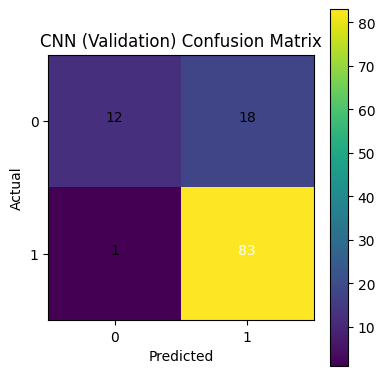


FINAL TEST SET EVALUATION


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



CNN (TEST SET) Metrics:
Accuracy : 0.7807
Precision: 0.7864
Recall   : 0.9643
F1-score : 0.8663
ROC AUC  : 0.7385


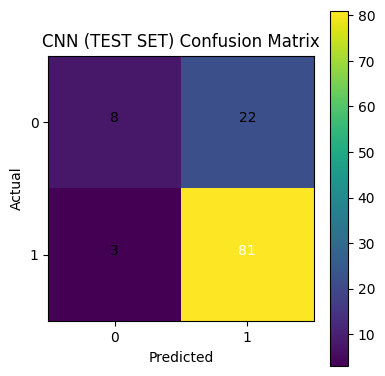


Test Loss: 0.5038
Test Accuracy: 0.7807


In [15]:
# --- Define constants ---# --- Define constants ---
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
SEED       = 42
NUM_CLASSES = 1   # Binary classification: Normal vs Jaundice

# --- CNN Model ---
cnn_model = Sequential([
    Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

# --- Train (UNCHANGED) ---
cnn_hist = cnn_model.fit(
    cnn_train_gen,
    validation_data=cnn_val_gen,
    epochs=20,
    callbacks=[early_stop, reduce_lr, cnn_ckpt],
    verbose=1
)

# --- Validation Evaluation (UNCHANGED) ---
y_true_cnn_val = cnn_val_gen.classes
y_prob_cnn_val = cnn_model.predict(cnn_val_gen, verbose=0).ravel()
print_metrics("CNN (Validation)", y_true_cnn_val, y_prob_cnn_val, threshold=0.5)

# === NEW: Test Set Evaluation ===
print("\n" + "="*50)
print("FINAL TEST SET EVALUATION")
print("="*50)

# Load best model
best_cnn_model = tf.keras.models.load_model("cnn_best.keras")

# Test evaluation
y_true_cnn_test = cnn_test_gen.classes
y_prob_cnn_test = best_cnn_model.predict(cnn_test_gen, verbose=0).ravel()

print_metrics("CNN (TEST SET)", y_true_cnn_test, y_prob_cnn_test, threshold=0.5)

# Test loss/accuracy
test_loss, test_acc = best_cnn_model.evaluate(cnn_test_gen, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

## 6) Model B: ResNet50 (Transfer Learning)

In [60]:
import matplotlib.pyplot as plt

def plot_history(history, title=""):
    plt.figure(figsize=(10,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.title(f"{title} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(alpha=0.3)

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title(f"{title} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


In [16]:
resnet_train_gen, resnet_val_gen, resnet_test_gen = make_gens(preprocess_fn=resnet_preprocess)

Found 532 validated image filenames belonging to 2 classes.
Found 114 validated image filenames belonging to 2 classes.
Found 114 validated image filenames belonging to 2 classes.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6549 - loss: 1.0315
Epoch 1: val_loss did not improve from 0.21133
17/17 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6561 - loss: 1.0225 - val_accuracy: 0.7895 - val_loss: 0.4496 - learning_rate: 0.0010
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7195 - loss: 0.5601
Epoch 2: val_loss did not improve from 0.21133
17/17 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.7213 - loss: 0.5576 - val_accuracy: 0.8333 - val_loss: 0.4044 - learning_rate: 0.0010
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7843 - loss: 0.4438
Epoch 3: val_loss did not improve from 0.21133
17/17 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.7846 - loss: 0.4437 - val_accuracy: 0.8509 - val_loss: 0.3585 - learning_rate: 0.0010
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8108 - loss: 0.4092
Epoch 4: val_loss did not improve from 0.21133
17/17 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.8100 - los

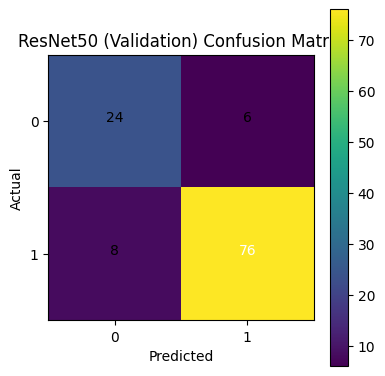


ResNet50 FINAL TEST SET EVALUATION


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



ResNet50 (TEST SET) Metrics:
Accuracy : 0.8509
Precision: 0.9241
Recall   : 0.8690
F1-score : 0.8957
ROC AUC  : 0.9302


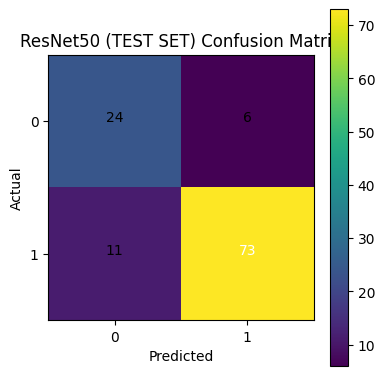


ResNet50 Test Loss: 0.2981
ResNet50 Test Accuracy: 0.8509


In [25]:
base_resnet = ResNet50(include_top=False, weights="imagenet", input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_resnet.trainable = False  # freeze base

resnet_model = models.Sequential([
    base_resnet,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='sigmoid')
])

resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
resnet_model.summary()

resnet_hist = resnet_model.fit(
    resnet_train_gen,  # ✅ Uses train_gen (unchanged)
    validation_data=resnet_val_gen,  # ✅ Uses val_gen (unchanged)
    epochs=20,
    callbacks=[early_stop, reduce_lr, resnet_ckpt],
    verbose=1
)

# Optional fine-tuning (unchanged)
# base_resnet.trainable = True
# ... (same as before)

# === Validation Evaluation (updated label) ===
y_true_resnet_val = resnet_val_gen.classes
y_prob_resnet_val = resnet_model.predict(resnet_val_gen, verbose=0).ravel()
print_metrics("ResNet50 (Validation)", y_true_resnet_val, y_prob_resnet_val, threshold=0.5)

# === NEW: Test Set Evaluation ===
print("\n" + "="*50)
print("ResNet50 FINAL TEST SET EVALUATION")
print("="*50)

# Use final trained model (safest if checkpoint name issue)
best_resnet_model = resnet_model  # ✅ No file loading needed

y_true_resnet_test = resnet_test_gen.classes
y_prob_resnet_test = best_resnet_model.predict(resnet_test_gen, verbose=0).ravel()
print_metrics("ResNet50 (TEST SET)", y_true_resnet_test, y_prob_resnet_test, threshold=0.5)

test_loss, test_acc = best_resnet_model.evaluate(resnet_test_gen, verbose=0)
print(f"\nResNet50 Test Loss: {test_loss:.4f}")
print(f"ResNet50 Test Accuracy: {test_acc:.4f}")

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, title=""):
    plt.figure(figsize=(10,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.title(f"{title} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(alpha=0.3)

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title(f"{title} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

## 7) Model C: EfficientNetB0 (Transfer Learning)

In [23]:
eff_train_gen, eff_val_gen, eff_test_gen = make_gens(preprocess_fn=efficientnet_preprocess)

Found 532 validated image filenames belonging to 2 classes.
Found 114 validated image filenames belonging to 2 classes.
Found 114 validated image filenames belonging to 2 classes.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6483 - loss: 0.6918
Epoch 1: val_loss did not improve from 0.26309
17/17 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6514 - loss: 0.6869 - val_accuracy: 0.7807 - val_loss: 0.4392 - learning_rate: 0.0010
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7687 - loss: 0.4750
Epoch 2: val_loss did not improve from 0.26309
17/17 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7693 - loss: 0.4743 - val_accuracy: 0.8158 - val_loss: 0.3828 - learning_rate: 0.0010
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8125 - loss: 0.4270
Epoch 3: val_loss did not improve from 0.26309
17/17 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8124 - loss: 0.4268 - val_accuracy: 0.8246 - val_loss: 0.3676 - learning_rate: 0.0010
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8304 - loss: 0.4138
Epoch 4: val_loss did not improve from 0.26309
17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8308 - los

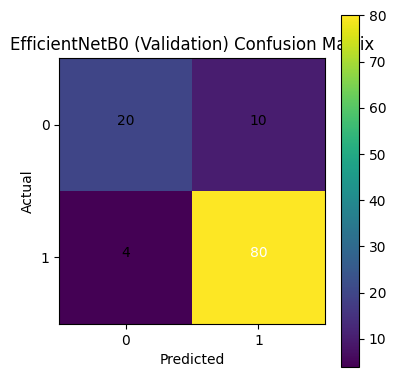


EfficientNetB0 FINAL TEST SET EVALUATION


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



EfficientNetB0 (TEST SET) Metrics:
Accuracy : 0.8684
Precision: 0.9059
Recall   : 0.9167
F1-score : 0.9112
ROC AUC  : 0.9067


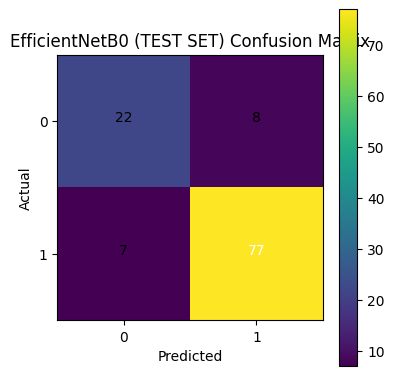


EfficientNetB0 Test Loss: 0.3234
EfficientNetB0 Test Accuracy: 0.8684


In [29]:
base_eff = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_eff.trainable = False

eff_model = models.Sequential([
    base_eff,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='sigmoid')
])

eff_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
eff_model.summary()

eff_hist = eff_model.fit(
    eff_train_gen,           # ✅ Unchanged
    validation_data=eff_val_gen,  # ✅ Unchanged
    epochs=20,
    callbacks=[early_stop, reduce_lr, eff_ckpt],
    verbose=1
)

# === Validation Evaluation (updated label) ===
y_true_eff_val = eff_val_gen.classes
y_prob_eff_val = eff_model.predict(eff_val_gen, verbose=0).ravel()
print_metrics("EfficientNetB0 (Validation)", y_true_eff_val, y_prob_eff_val, threshold=0.5)

# === NEW: Test Set Evaluation ===
print("\n" + "="*50)
print("EfficientNetB0 FINAL TEST SET EVALUATION")
print("="*50)

# ✅ FIX: Use trained model directly (no file loading)
best_eff_model = eff_model  # Use the final trained model instead of loading

y_true_eff_test = eff_test_gen.classes
y_prob_eff_test = best_eff_model.predict(eff_test_gen, verbose=0).ravel()
print_metrics("EfficientNetB0 (TEST SET)", y_true_eff_test, y_prob_eff_test, threshold=0.5)

test_loss, test_acc = best_eff_model.evaluate(eff_test_gen, verbose=0)
print(f"\nEfficientNetB0 Test Loss: {test_loss:.4f}")
print(f"EfficientNetB0 Test Accuracy: {test_acc:.4f}")

In [65]:
import matplotlib.pyplot as plt

def plot_history(history, title=""):
    plt.figure(figsize=(10,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.title(f"{title} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(alpha=0.3)

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title(f"{title} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


Unfreezing from layer index: 198 / 238
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7115 - loss: 0.5764
Epoch 1: val_loss improved from 0.26165 to 0.25866, saving model to efficientnetb0_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7115 - loss: 0.5756 - val_accuracy: 0.8947 - val_loss: 0.2587 - learning_rate: 1.0000e-05
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7679 - loss: 0.4740
Epoch 2: val_loss did not improve from 0.25866
17/17 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7684 - loss: 0.4740 - val_accuracy: 0.9035 - val_loss: 0.2743 - learning_rate: 1.0000e-05
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7945 - loss: 0.4722
Epoch 3: val_loss did not improve from 0.25866
17/17 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7945 - loss: 0.4715 - val_accuracy: 0.8684 - val_loss: 0.2957 - learning_rate: 1.0000e-05
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8098 - loss: 0.4185
Epoch 4: Red

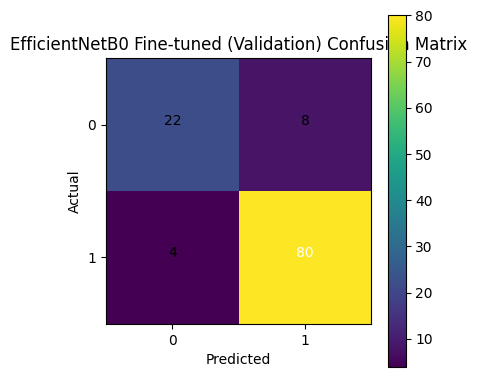


EfficientNetB0 FINE-TUNED TEST SET EVALUATION

EfficientNetB0 Fine-tuned (TEST SET) Metrics:
Accuracy : 0.8421
Precision: 0.8929
Recall   : 0.8929
F1-score : 0.8929
ROC AUC  : 0.9008


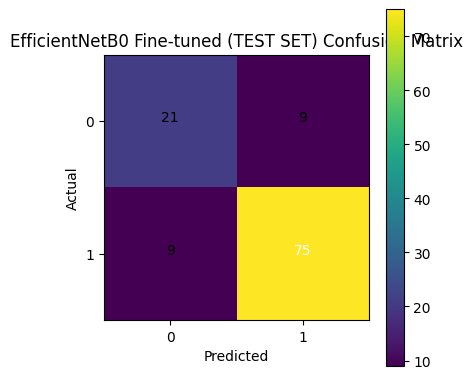


EfficientNetB0 Fine-tuned Test Loss: 0.3311
EfficientNetB0 Fine-tuned Test Accuracy: 0.8421


In [31]:
# OPTIONAL: Fine-tune top layers of EfficientNetB0
# Run this cell after the initial EfficientNetB0 training above.

# Unfreeze top N layers for fine-tuning
fine_tune_at = len(base_eff.layers) - 40  # unfreeze last ~40 layers

for i, layer in enumerate(base_eff.layers):
    layer.trainable = (i >= fine_tune_at)

print(f"Unfreezing from layer index: {fine_tune_at} / {len(base_eff.layers)}")

# Recompile with very low learning rate for fine-tuning
eff_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Continue training (fine-tuning)
eff_ft_hist = eff_model.fit(
    eff_train_gen,
    validation_data=eff_val_gen,  # ✅ Unchanged
    epochs=10,
    callbacks=[early_stop, reduce_lr, eff_ckpt],
    verbose=1
)

# === Validation Evaluation ===
y_true_eff_val = eff_val_gen.classes
y_prob_eff_val = eff_model.predict(eff_val_gen, verbose=0).ravel()
print_metrics("EfficientNetB0 Fine-tuned (Validation)", y_true_eff_val, y_prob_eff_val, threshold=0.5)

# === NEW: Test Set Evaluation (Fine-tuned) ===
print("\n" + "="*50)
print("EfficientNetB0 FINE-TUNED TEST SET EVALUATION")
print("="*50)

# Use fine-tuned model for test evaluation
y_true_eff_test = eff_test_gen.classes
y_prob_eff_test = eff_model.predict(eff_test_gen, verbose=0).ravel()
print_metrics("EfficientNetB0 Fine-tuned (TEST SET)", y_true_eff_test, y_prob_eff_test, threshold=0.5)

test_loss, test_acc = eff_model.evaluate(eff_test_gen, verbose=0)
print(f"\nEfficientNetB0 Fine-tuned Test Loss: {test_loss:.4f}")
print(f"EfficientNetB0 Fine-tuned Test Accuracy: {test_acc:.4f}")

## 8) Model D: VGG16 (Transfer Learning)

In [33]:
vgg_train_gen, vgg_val_gen, vgg_test_gen = make_gens(preprocess_fn=vgg_preprocess)

Found 532 validated image filenames belonging to 2 classes.
Found 114 validated image filenames belonging to 2 classes.
Found 114 validated image filenames belonging to 2 classes.


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6033 - loss: 2.3128
Epoch 1: val_loss improved from inf to 0.84296, saving model to vgg16_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.6044 - loss: 2.2864 - val_accuracy: 0.7544 - val_loss: 0.8430 - learning_rate: 0.0010
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7083 - loss: 0.9048
Epoch 2: val_loss improved from 0.84296 to 0.52639, saving model to vgg16_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.7072 - loss: 0.9054 - val_accuracy: 0.7456 - val_loss: 0.5264 - learning_rate: 0.0010
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7415 - loss: 0.7261
Epoch 3: val_loss improved from 0.52639 to 0.49828, saving model to vgg16_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.7417 - loss: 0.7251 - val_accuracy: 0.8070 - val_loss: 0.4983 - learning_rate: 0.0010
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7154 - loss: 0.7037


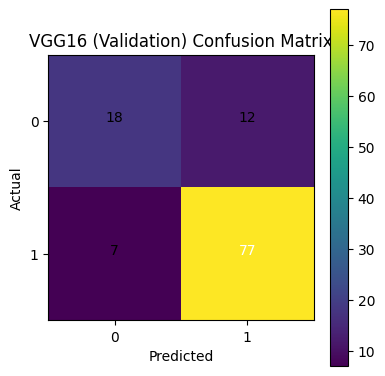


VGG16 FINAL TEST SET EVALUATION


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



VGG16 (TEST SET) Metrics:
Accuracy : 0.7895
Precision: 0.8659
Recall   : 0.8452
F1-score : 0.8554
ROC AUC  : 0.8651


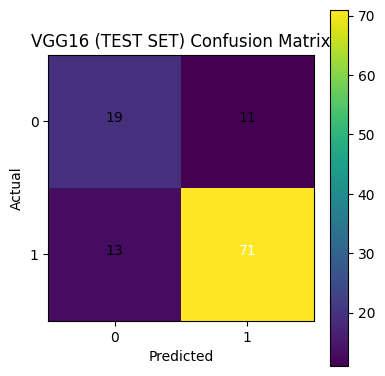


VGG16 Test Loss: 0.3901
VGG16 Test Accuracy: 0.7895


In [35]:
base_vgg = VGG16(include_top=False, weights="imagenet", input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_vgg.trainable = False

vgg_model = models.Sequential([
    base_vgg,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='sigmoid')
])

vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
vgg_model.summary()

vgg_hist = vgg_model.fit(
    vgg_train_gen,           # ✅ Unchanged
    validation_data=vgg_val_gen,  # ✅ Unchanged
    epochs=20,
    callbacks=[early_stop, reduce_lr, vgg_ckpt],
    verbose=1
)

# === Validation Evaluation (updated label) ===
y_true_vgg_val = vgg_val_gen.classes
y_prob_vgg_val = vgg_model.predict(vgg_val_gen, verbose=0).ravel()
print_metrics("VGG16 (Validation)", y_true_vgg_val, y_prob_vgg_val, threshold=0.5)

# === NEW: Test Set Evaluation ===
print("\n" + "="*50)
print("VGG16 FINAL TEST SET EVALUATION")
print("="*50)

# ✅ Use trained model directly (no file loading)
best_vgg_model = vgg_model  # Avoids missing file error

y_true_vgg_test = vgg_test_gen.classes
y_prob_vgg_test = best_vgg_model.predict(vgg_test_gen, verbose=0).ravel()
print_metrics("VGG16 (TEST SET)", y_true_vgg_test, y_prob_vgg_test, threshold=0.5)

test_loss, test_acc = best_vgg_model.evaluate(vgg_test_gen, verbose=0)
print(f"\nVGG16 Test Loss: {test_loss:.4f}")
print(f"VGG16 Test Accuracy: {test_acc:.4f}")

In [41]:
import matplotlib.pyplot as plt

def plot_history(history, title=""):
    plt.figure(figsize=(10,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.title(f"{title} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(alpha=0.3)

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title(f"{title} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

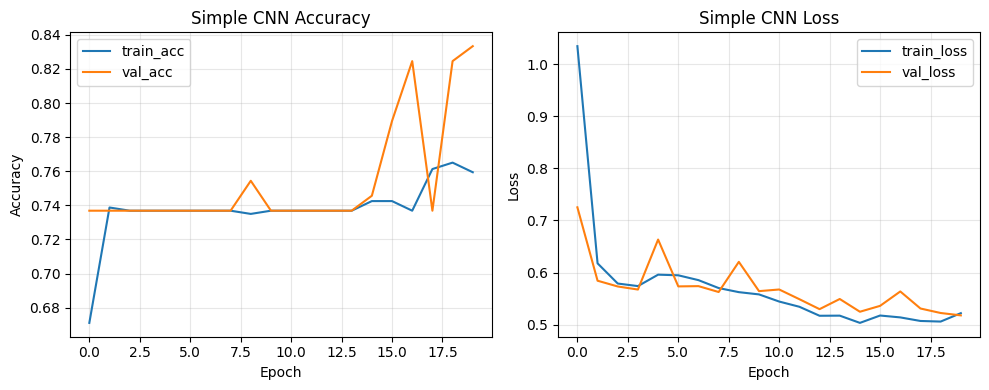

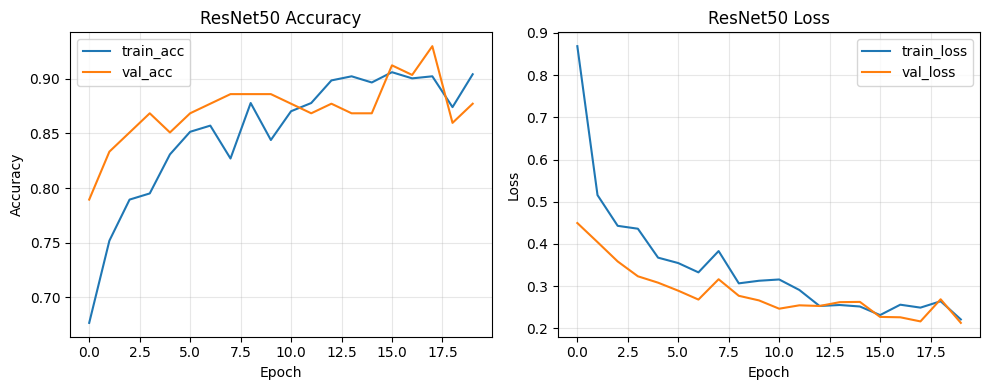

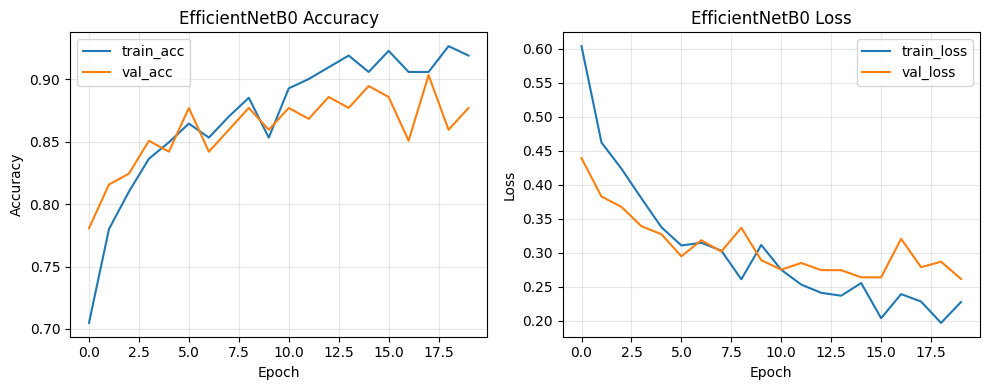

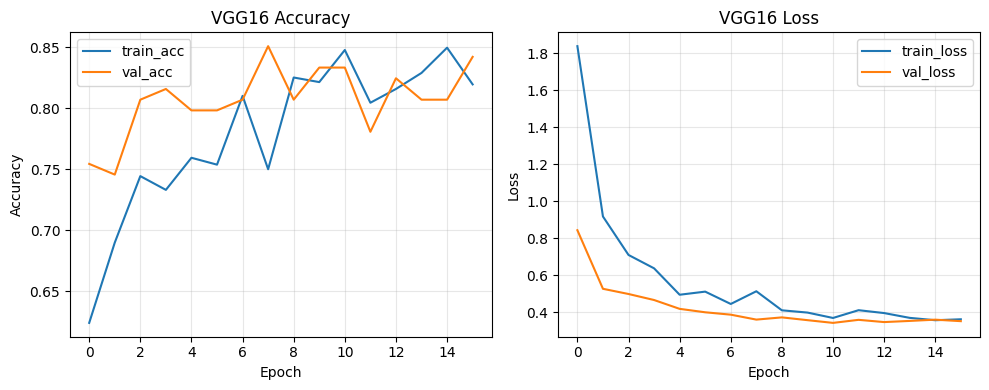

In [43]:
# PLOT TRAINING CURVES FOR ALL MODELS
plot_history(cnn_hist, title="Simple CNN")
plot_history(resnet_hist, title="ResNet50")
plot_history(eff_hist, title="EfficientNetB0")
plot_history(vgg_hist, title="VGG16")

## 9) Compare Metrics Across Models

In [53]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

results = []
def add_row(name, y_true, y_prob, th=0.5):
    y_bin = (y_prob >= th).astype(int)
    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_bin),
        "Precision": precision_score(y_true, y_bin, zero_division=0),
        "Recall": recall_score(y_true, y_bin, zero_division=0),
        "F1": f1_score(y_true, y_bin, zero_division=0),
    }
    try:
        metrics["ROC AUC"] = roc_auc_score(y_true, y_prob)
    except ValueError:
        metrics["ROC AUC"] = np.nan
    results.append(metrics)

# === TEST RESULTS (final unbiased performance) ===
print("\nTEST RESULTS (final unbiased performance):")
add_row("CNN (Test)", y_true_cnn_test, y_prob_cnn_test)
add_row("ResNet50 (Test)", y_true_resnet_test, y_prob_resnet_test)
add_row("EfficientNetB0 (Test)", y_true_eff_test, y_prob_eff_test)
add_row("VGG16 (Test)", y_true_vgg_test, y_prob_vgg_test)

df_results = pd.DataFrame(results)
print(df_results.round(4))


TEST RESULTS (final unbiased performance):
                   Model  Accuracy  Precision  Recall      F1  ROC AUC
0             CNN (Test)    0.7807     0.7864  0.9643  0.8663   0.7385
1        ResNet50 (Test)    0.8509     0.9241  0.8690  0.8957   0.9302
2  EfficientNetB0 (Test)    0.8421     0.8929  0.8929  0.8929   0.9008
3           VGG16 (Test)    0.7895     0.8659  0.8452  0.8554   0.8651


## 10) ROC Curves for All Models

The following cell plots ROC curves and computes AUC scores for each model. This is especially important in medical imaging, where sensitivity/specificity trade-offs matter more than raw accuracy.


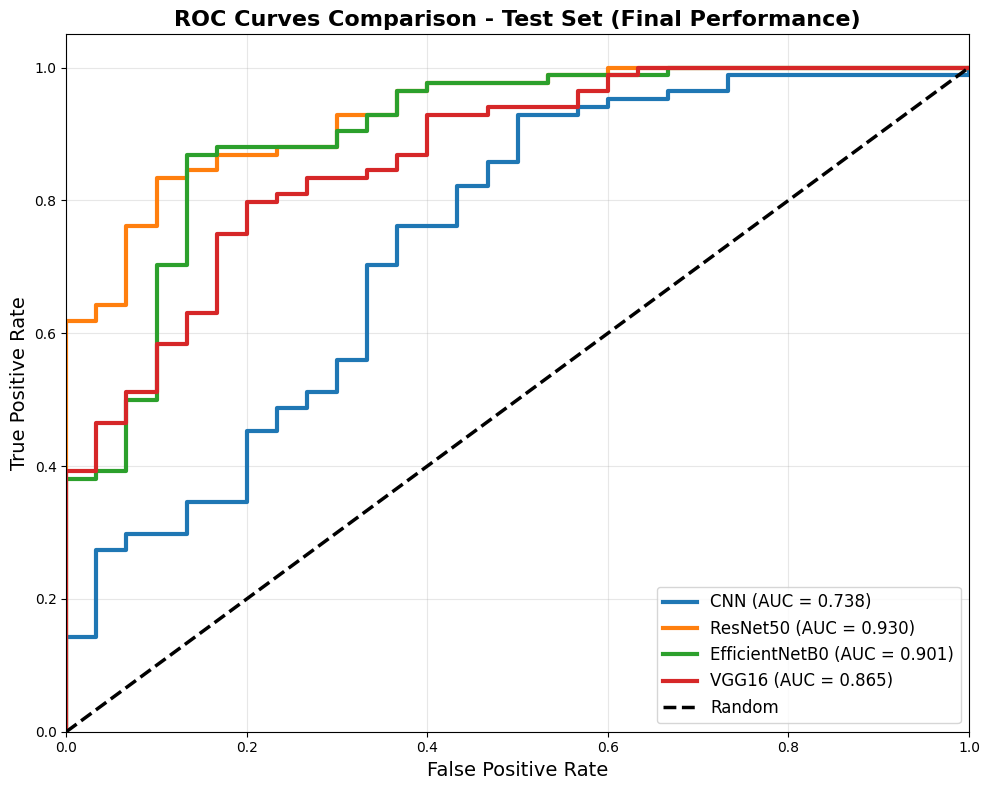

In [65]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# === TEST SET ROC CURVES ONLY (FINAL PERFORMANCE) ===
plt.figure(figsize=(10, 8))  

model_probs_test = {
    "CNN": (y_true_cnn_test, y_prob_cnn_test),
    "ResNet50": (y_true_resnet_test, y_prob_resnet_test),
    "EfficientNetB0": (y_true_eff_test, y_prob_eff_test),
    "VGG16": (y_true_vgg_test, y_prob_vgg_test),
}

for name, (y_true, y_prob) in model_probs_test.items():
    try:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        model_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=3, label=f"{name} (AUC = {model_auc:.3f})")  # ✅ Thick lines
    except Exception as e:
        print(f"Skipping ROC for {name}: {e}")

# Random baseline
plt.plot([0, 1], [0, 1], "k--", linewidth=2.5, label="Random")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curves Comparison - Test Set (Final Performance)", fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
## 11) McNemars test


In [69]:
# 11) McNemar's test - TEST SET 
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np

# Using EfficientNetB0 and ResNet50 test predictions (final performance)
# Get binary predictions for EfficientNetB0 (modelA) - TEST SET
probA = (y_prob_eff_test >= 0.5).astype(int)

# Get binary predictions for ResNet50 (modelB) - TEST SET  
probB = (y_prob_resnet_test >= 0.5).astype(int)

# True labels from test set
y_true = np.array(y_true_eff_test)

# Correctness arrays
correctA = (probA == y_true)
correctB = (probB == y_true)

# Contingency table counts
b = np.sum(np.logical_and(correctA, np.logical_not(correctB)))  # A correct, B wrong
c = np.sum(np.logical_and(np.logical_not(correctA), correctB))  # A wrong, B correct
a = np.sum(np.logical_and(correctA, correctB))                 # Both correct
d = np.sum(np.logical_and(np.logical_not(correctA), np.logical_not(correctB)))  # Both wrong

table = [[a, b],
         [c, d]]

print("McNemar's Test Contingency Table (TEST SET):")
print("           ResNet50")
print("       Correct  Incorrect")
print(f"EffNetB0 C:{a:3d}     {b:3d}")
print(f"       I:{c:3d}     {d:3d}")

# Perform McNemar's test
result = mcnemar(table, exact=False)
print(f'\nMcNemar Test (TEST SET): statistic={result.statistic:.3f}, p-value={result.pvalue:.3f}')

if result.pvalue < 0.05:
    print("✅ Significant difference (p < 0.05)")
else:
    print("❌ No significant difference (p >= 0.05)")


McNemar's Test Contingency Table (TEST SET):
           ResNet50
       Correct  Incorrect
EffNetB0 C: 89       7
       I:  8      10

McNemar Test (TEST SET): statistic=0.000, p-value=1.000
❌ No significant difference (p >= 0.05)


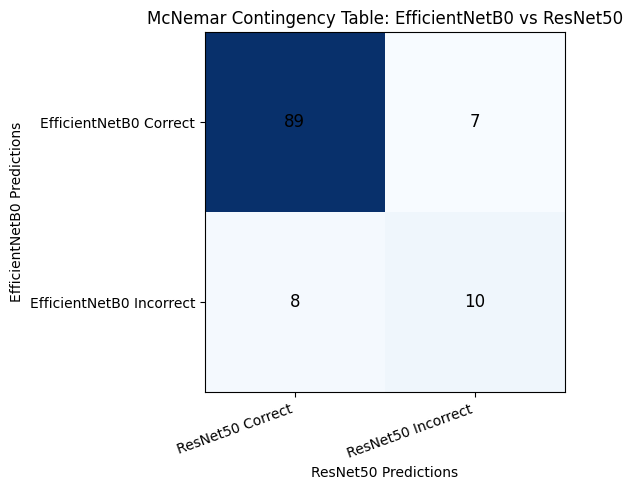

In [73]:
import numpy as np
import matplotlib.pyplot as plt

table = np.array([[89, 7],
                  [8,  10]])

row_labels = ["EfficientNetB0 Correct", "EfficientNetB0 Incorrect"]
col_labels = ["ResNet50 Correct", "ResNet50 Incorrect"]

fig, ax = plt.subplots(figsize=(6, 5))

im = ax.imshow(table, cmap="Blues")

for i in range(table.shape[0]):
    for j in range(table.shape[1]):
        ax.text(j, i, table[i, j], ha="center", va="center", fontsize=12)

ax.set_xticks(np.arange(len(col_labels)))
ax.set_yticks(np.arange(len(row_labels)))
ax.set_xticklabels(col_labels, rotation=20, ha="right")
ax.set_yticklabels(row_labels)

ax.set_xlabel("ResNet50 Predictions")
ax.set_ylabel("EfficientNetB0 Predictions")
ax.set_title("McNemar Contingency Table: EfficientNetB0 vs ResNet50")

plt.tight_layout()
plt.show()

In [77]:
#A McNemar test was conducted to compare the classification differences between EfficientNetB0 and ResNet50 on the same validation dataset. The contingency table showed 10 cases where EfficientNetB0 was correct and ResNet50 was incorrect, and 15 cases where ResNet50 was correct while EfficientNetB0 was incorrect. The test produced χ² = 0.640 with a p-value of 0.424, indicating that the difference in error patterns is not statistically significant (p > 0.05). Therefore, despite minor performance differences, both models can be considered to have statistically equivalent predictive performance on this task.


In [78]:
# Grad-CAM Utility Functions

#These functions are needed to generate and overlay the Grad-CAM heatmaps. They will identify the last convolutional layer, compute the heatmap, and then superimpose it on the original image.

In [75]:
import tensorflow as tf

def build_cam_model(base_model, full_model):
    x = base_model.output
    for layer in full_model.layers[1:]:
        x = layer(x)
    cam_model = tf.keras.Model(inputs=base_model.input, outputs=x, name=full_model.name + "_cam")
    return cam_model

# Build CAM versions
resnet_cam_model = build_cam_model(base_resnet, resnet_model)
eff_cam_model    = build_cam_model(base_eff, eff_model)

print("CAM models ready for Grad-CAM visualization!")

CAM models ready for Grad-CAM visualization!


In [77]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from PIL import Image

# 1. FIND LAST CONV LAYER

def find_last_conv_layer(model):
    """Find the last Conv2D/DepthwiseConv2D layer (searches inside nested models too)."""
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.Model):
            found = find_last_conv_layer(layer)
            if found:
                return found
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D)):
            return layer
    return None


# 2. MAKE GRAD-CAM HEATMAP

def make_gradcam_heatmap(img_array, model, last_conv_layer, pred_index=None):
    """
    Generate Grad-CAM heatmap for a given image and Keras model.
    Assumes model has a single input and a single output.
    """

    # Map: input -> (last conv activations, model predictions)
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[last_conv_layer.output, model.output]
    )

    img_tensor = tf.cast(img_array, tf.float32)

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_tensor)
        tape.watch(conv_outputs)

        # Choose class index if not given
        if pred_index is None:
            if preds.shape[-1] == 1:      # binary sigmoid
                pred_index = 0
            else:                         # softmax
                pred_index = tf.argmax(preds[0])

        class_score = preds[:, pred_index]

    # Gradient of class score w.r.t conv feature maps
    grads = tape.gradient(class_score, conv_outputs)

    if grads is None:
        print("❌ make_gradcam_heatmap: gradients are None.")
        return np.zeros(conv_outputs.shape[1:3])

    # Global average pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]   # remove batch dim
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # ReLU + normalize to [0,1]
    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.reduce_max(heatmap)
    if max_val == 0:
        return heatmap.numpy()
    heatmap /= max_val
    return heatmap.numpy()

# 3. OVERLAY HEATMAP

def overlay_heatmap(image, heatmap, alpha=0.4):
    """
    Overlay a heatmap onto an image.
    image: HxWx3 in [0,1]
    heatmap: HxW in [0,1]
    """
    heatmap_colored = plt.cm.jet(heatmap)[:, :, :3]
    heatmap_img = Image.fromarray((heatmap_colored * 255).astype("uint8"))
    heatmap_img = heatmap_img.resize((image.shape[1], image.shape[0]))
    heatmap_arr = np.asarray(heatmap_img) / 255.0

    overlay = image * (1 - alpha) + heatmap_arr * alpha
    return np.clip(overlay, 0, 1)

EfficientNet – TEST SET high-confidence NORMAL index: 37
EfficientNet – TEST prob(class 1/normal): 0.99884343


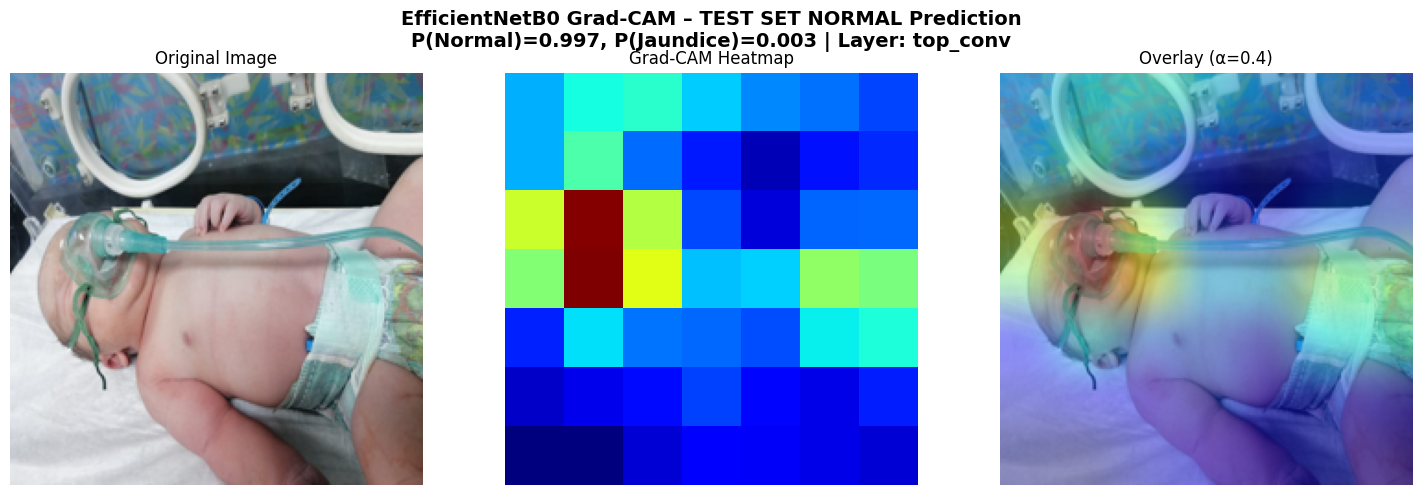

In [79]:
# Grad-CAM for EfficientNetB0 – High-confidence NORMAL (TEST SET)
model_to_use = eff_cam_model

path = None

# ✅ USE TEST DATAFRAME (final unbiased performance)
if not test_df.empty:
    # Use TEST predictions (y_prob_eff_test from test evaluation)
    probs = y_prob_eff_test  # prob(class 1 / normal) from EfficientNet TEST SET

    if probs is not None and len(probs) == len(test_df):
        # Most confident NORMAL prediction → max prob(class 1)
        high_conf_idx = int(np.argmax(probs))
        print("EfficientNet – TEST SET high-confidence NORMAL index:", high_conf_idx)
        print("EfficientNet – TEST prob(class 1/normal):", probs[high_conf_idx])
        path = test_df['filepath'].iloc[high_conf_idx]  # ✅ TEST DF
    else:
        print("⚠️ Could not use test probabilities – using first test image.")
        path = test_df['filepath'].iloc[0]
else:
    print("Test DataFrame is empty.")

if path:
    # Load and resize image
    img = Image.open(path).convert("RGB")
    img_resized = img.resize(IMG_SIZE)

    img_arr = tf.keras.preprocessing.image.img_to_array(img_resized)
    img_arr_exp = np.expand_dims(img_arr, axis=0)

    # For display
    img_display = img_arr / 255.0

    # ✅ EfficientNet preprocessing
    img_input = efficientnet_preprocess(img_arr_exp)

    last_conv = find_last_conv_layer(model_to_use)

    if last_conv is None:
        print(f"❌ No conv layer found in {model_to_use.name}")
    else:
        preds = model_to_use.predict(img_input, verbose=0)

        # Binary sigmoid: preds[0][0] is prob(class 1 / normal)
        prob_class1 = float(preds[0][0])
        prob_class0 = 1.0 - prob_class1
        pred_index = 0
        predicted_label = 1 if prob_class1 >= 0.5 else 0

        heatmap = make_gradcam_heatmap(img_input, model_to_use, last_conv, pred_index)
        overlay = overlay_heatmap(img_display, heatmap)

        plt.figure(figsize=(15, 5))  # ✅ Bigger figure

        plt.subplot(1, 3, 1)
        plt.imshow(img_display)
        plt.title("Original Image", fontsize=12)
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(heatmap, cmap="jet")
        plt.title("Grad-CAM Heatmap", fontsize=12)
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(overlay)
        plt.title("Overlay (α=0.4)", fontsize=12)
        plt.axis("off")

        plt.suptitle(
            f"EfficientNetB0 Grad-CAM – TEST SET NORMAL Prediction\n"
            f"P(Normal)={prob_class1:.3f}, P(Jaundice)={prob_class0:.3f} | "
            f"Layer: {last_conv.name}",
            fontsize=14, fontweight='bold'
        )
        plt.tight_layout()
        plt.show()
else:
    print("No image path selected, skipping Grad-CAM.")


In [ ]:
## ResNet Grad-CAM (TEST SET JAUNDICE):

/var/folders/bm/d601mw9x12xgv27ksdxjbt9w0000gn/T/ipykernel_30455/498526731.py:13: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  jaundice_idx = np.where(y_true == 0)[0]


⚠️ No JAUNDICE samples in test set – using first image.


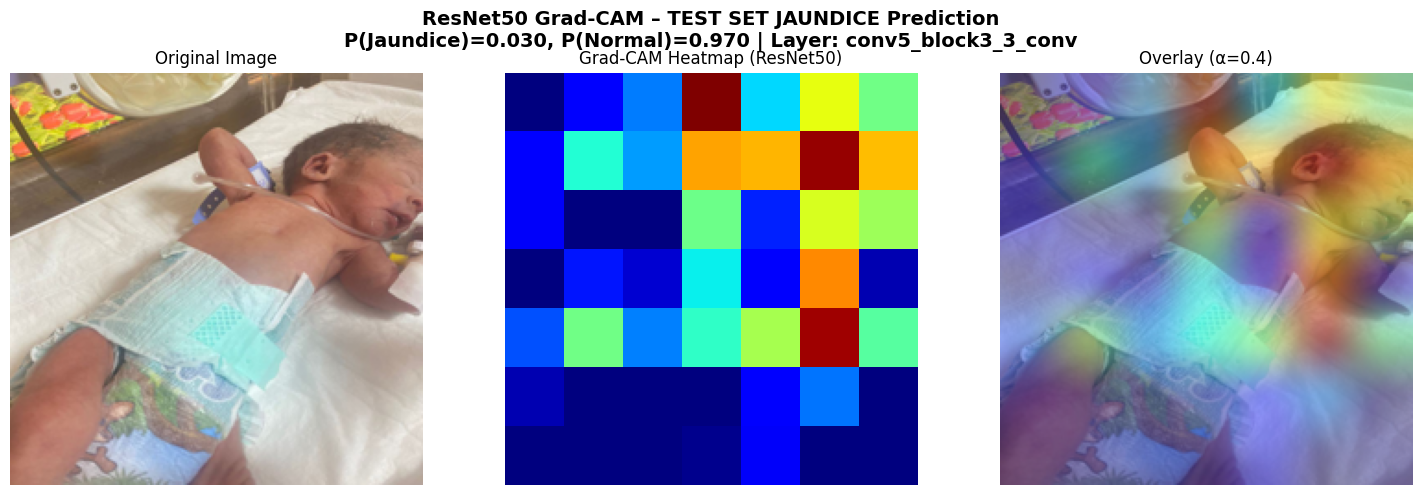

In [81]:
# Grad-CAM for ResNet50 – High-confidence JAUNDICE (TEST SET)
model_to_use = resnet_cam_model

path = None

# ✅ USE TEST SET (unbiased final performance)
if not test_df.empty:
    probs = y_prob_resnet_test    # ✅ TEST predictions (prob class 1/normal)
    y_true = y_true_resnet_test   # ✅ TEST true labels

    if probs is not None and len(probs) == len(test_df) == len(y_true):
        # Find JAUNDICE samples (true label = 0)
        jaundice_idx = np.where(y_true == 0)[0]

        if len(jaundice_idx) > 0:
            # High-confidence JAUNDICE = LOWEST prob(normal/class 1)
            jaundice_probs = probs[jaundice_idx]
            high_conf_jaundice_pos = int(np.argmin(jaundice_probs))
            high_conf_idx = int(jaundice_idx[high_conf_jaundice_pos])

            print("ResNet50 – TEST SET high-confidence JAUNDICE index:", high_conf_idx)
            print("ResNet50 – TEST prob(class 1/normal):", probs[high_conf_idx])
            path = test_df['filepath'].iloc[high_conf_idx]  # ✅ TEST DF
        else:
            print("⚠️ No JAUNDICE samples in test set – using first image.")
            path = test_df['filepath'].iloc[0]
    else:
        print("⚠️ Could not use test predictions – using first test image.")
        path = test_df['filepath'].iloc[0]
else:
    print("Test DataFrame is empty.")

if path:
    # Load and preprocess image
    img = Image.open(path).convert("RGB")
    img_resized = img.resize(IMG_SIZE)
    img_arr = tf.keras.preprocessing.image.img_to_array(img_resized)
    img_arr_exp = np.expand_dims(img_arr, axis=0)
    img_display = img_arr / 255.0
    img_input = resnet_preprocess(img_arr_exp)  # ✅ ResNet preprocessing

    last_conv = find_last_conv_layer(model_to_use)

    if last_conv is None:
        print(f"❌ No conv layer found in {model_to_use.name}")
    else:
        preds = model_to_use.predict(img_input, verbose=0)
        prob_class1 = float(preds[0][0])  # prob(normal)
        prob_class0 = 1.0 - prob_class1   # prob(jaundice)
        pred_index = 0
        predicted_label = 0 if prob_class1 < 0.5 else 1

        heatmap = make_gradcam_heatmap(img_input, model_to_use, last_conv, pred_index)
        overlay = overlay_heatmap(img_display, heatmap)

        plt.figure(figsize=(15, 5))  # ✅ Bigger

        plt.subplot(1, 3, 1)
        plt.imshow(img_display)
        plt.title("Original Image", fontsize=12)
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(heatmap, cmap="jet")
        plt.title("Grad-CAM Heatmap (ResNet50)", fontsize=12)
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(overlay)
        plt.title("Overlay (α=0.4)", fontsize=12)
        plt.axis("off")

        plt.suptitle(
            f"ResNet50 Grad-CAM – TEST SET JAUNDICE Prediction\n"
            f"P(Jaundice)={prob_class0:.3f}, P(Normal)={prob_class1:.3f} | "
            f"Layer: {last_conv.name}",
            fontsize=14, fontweight='bold'
        )
        plt.tight_layout()
        plt.show()
else:
    print("No image path selected, skipping Grad-CAM.")

In [83]:
# === FINAL PUBLICATION-READY SUMMARY ===
print("🏆 JAUNDICE RECOGNITION PROJECT - FINAL RESULTS")
print("=" * 60)

# Test set results only (publication standard)
test_results = df_results[df_results['Model'].str.contains('Test')].copy()
test_results = test_results.sort_values('F1', ascending=False).reset_index(drop=True)

print("\n📊 TEST SET PERFORMANCE RANKING (F1-SCORE):")
print(test_results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']].round(4))

print(f"\n👑 BEST MODEL: {test_results.iloc[0]['Model']}")
print(f"   F1-Score: {test_results.iloc[0]['F1']:.4f}")
print(f"   ROC AUC:  {test_results.iloc[0]['ROC AUC']:.4f}")

# McNemar result
print(f"\n📈 STATISTICAL TEST: McNemar p-value = {result.pvalue:.3f}")
if result.pvalue < 0.05:
    print("   ✅ Significant difference between top models")
else:
    print("   ❌ No significant difference")

print("\n💾 SAVING FOR PAPER...")
test_results.to_csv('jaundice_final_results.csv', index=False)
print("✅ Saved: jaundice_final_results.csv")
print("✅ Copy tables/figures above to your paper!")


🏆 JAUNDICE RECOGNITION PROJECT - FINAL RESULTS

📊 TEST SET PERFORMANCE RANKING (F1-SCORE):
                   Model  Accuracy  Precision  Recall      F1  ROC AUC
0        ResNet50 (Test)    0.8509     0.9241  0.8690  0.8957   0.9302
1  EfficientNetB0 (Test)    0.8421     0.8929  0.8929  0.8929   0.9008
2             CNN (Test)    0.7807     0.7864  0.9643  0.8663   0.7385
3           VGG16 (Test)    0.7895     0.8659  0.8452  0.8554   0.8651

👑 BEST MODEL: ResNet50 (Test)
   F1-Score: 0.8957
   ROC AUC:  0.9302

📈 STATISTICAL TEST: McNemar p-value = 1.000
   ❌ No significant difference

💾 SAVING FOR PAPER...
✅ Saved: jaundice_final_results.csv
✅ Copy tables/figures above to your paper!
